In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import wandb
run = wandb.init()
api = wandb.Api()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: middelman. Use `wandb login --relogin` to force relogin


In [2]:
artifact = run.use_artifact('middelman/tabnet_rossmann_mse/TabNet_model:v43', type='model')
artifact_dir = artifact.download()

catboost_project_name = "middelman/tabnet_rossmann_mse"
catboost_metric_name = "orig_valid_rmse"

tabnet_runs = api.runs(catboost_project_name)

tabnet_sorted_runs = sorted(tabnet_runs, key=lambda r: r.summary.get(catboost_metric_name, float('inf')))


wandb: Downloading large artifact TabNet_model:v43, 54.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [3]:
print(f"{artifact_dir}/tabnet_regressor_{tabnet_sorted_runs[0].id}.zip")

./artifacts/TabNet_model:v43/tabnet_regressor_wfsib2kr.zip


In [4]:
tabnet_sorted_runs[0].summary

{'orig_valid_rmse': 752.4065361219656, 'orig_train_mse': 354045.84552752576, 'orig_train_rmse': 595.0175169921687, '_wandb': {'runtime': 4491}, 'min_train_rmse': 0.08339159848985807, 'min_valid_rmse': 0.10230967050688368, 'min_orig_test_rmse': 728.57663501844, 'min_orig_valid_rmse': 732.950378207791, 'valid_mse': 0.0113328853450658, 'train_rmse': 0.08492769600424928, 'orig_test_rmse': 751.0118024651543, '_runtime': 4462.936288118362, 'test_mse': 0.011423432724322773, 'test_rmse': 0.10688045997432258, 'train_mse': 0.007212713548590178, 'valid_rmse': 0.10645602540516812, 'lr': 0.017456047871880424, 'loss': 0.00898385307854519, '_step': 82, 'min_test_rmse': 0.10230095758949057, 'orig_valid_mse': 566115.5955990547, '_timestamp': 1682964095.244022, 'orig_test_mse': 564018.72744196, 'min_orig_train_rmse': 587.3452429266597}

In [5]:
#load the TabNet regressor model from the artifact using the id of the run with the lowest validation score

from pytorch_tabnet.tab_model import TabNetRegressor
model = TabNetRegressor()
model.load_model("/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/artifacts/TabNet_model:v43/tabnet_model_g7i3zs1h.zip")

/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [6]:
import pandas as pd
import numpy as np

print('Reading the data...')
train = pd.read_parquet(r'/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/train_processed.parquet')
print("Read:", train.shape)

#select only a couple of columns

train = train[['Store',
                'DayOfWeek',
                'Promo',
                'StateHoliday',
                'SchoolHoliday',
                'StoreType',
                'Assortment',
                'CompetitionDistance',
                'Promo2SinceWeek',
                'Promo2SinceYear',
                'Year',
                'Month',
                'Day',
                'WeekOfYear',
                'CompetitionOpen',
                'PromoOpen',
                'IsPromoMonth',
                'Sales',
                'Set']]


if "Set" not in train.columns:
    train.reset_index(inplace=True, drop=True)
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index


    
categorical_columns = ['Store',
                        'DayOfWeek',
                        'Promo',
                        'StateHoliday',
                        'SchoolHoliday',
                        'StoreType',
                        'Assortment',
                        # 'Year',
                        # 'Month',
                        # 'Day',
                        # 'WeekOfYear',
                        'IsPromoMonth']


# split x and y
X_all, y_all = train.drop(columns = ['Sales', 'Set']), np.log1p(train[['Sales']].values)

temp = X_all.fillna("MissingValue")
nan_mask = temp.ne("MissingValue").astype(int)

X_train = X_all.iloc[train_indices]
X_test =  X_all.iloc[test_indices]
X_valid =  X_all.iloc[valid_indices]

y_train = y_all[train_indices]
y_test =  y_all[test_indices]
y_valid =  y_all[valid_indices]

Reading the data...
Read: (804056, 19)


In [7]:
y_valid_pred = model.predict(X_valid.values)


In [8]:
#convert to the right domain   
y_valid_pred = np.expm1(y_valid_pred)
print(y_valid_pred)

[[4807.5293]
 [5374.9326]
 [3792.5566]
 ...
 [3358.9658]
 [5257.6006]
 [3910.5107]]


In [9]:
from sklearn.metrics import mean_squared_error
valid_score = mean_squared_error(np.expm1(y_valid), y_valid_pred, squared=False)
print(valid_score)


736.9678581644301


In [27]:
#Calculate the individual losses (mean squared error) 

losses = [mean_squared_error([true], [pred], squared=False) for true, pred in zip(np.expm1(y_valid), y_valid_pred)]



In [28]:
#Load Catboost losses:
df_loss = pd.DataFrame()

df_loss['catboost_losses'] = pd.read_parquet('/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/catboost_losses.parquet')['catboost_losses']

df_loss['tabnet_losses'] = losses


In [29]:
df_loss.describe()

catboost_losses  tabnet_losses
count     79984.000000   79984.000000
mean        419.880650     499.034534
std         469.071921     542.300502
min           0.001555       0.002441
25%         142.399357     165.685547
50%         309.095821     363.859619
75%         558.371307     664.380371
max       24643.157318   25500.249023

In [30]:
df_loss['catboost_losses']

0         56.460006
1        546.811825
2        206.839786
3        220.505546
4        265.665262
            ...    
79979    129.488680
79980    155.752753
79981    222.475350
79982    191.963216
79983     87.433687
Name: catboost_losses, Length: 79984, dtype: float64

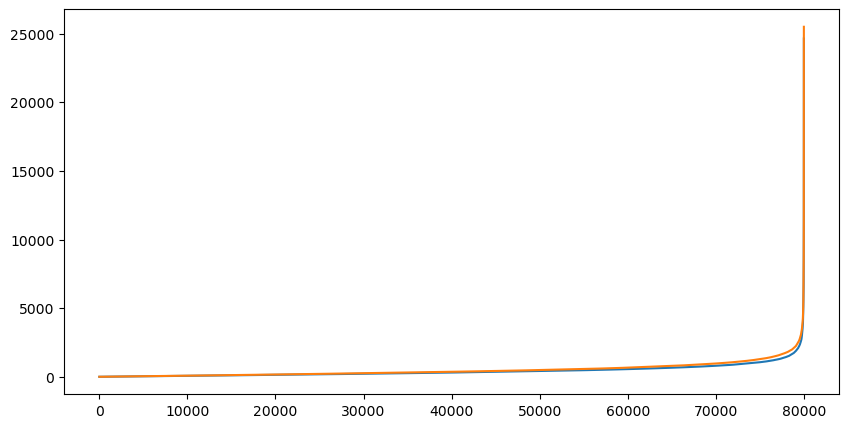

In [31]:
import matplotlib.pyplot as plt

# Sort losses
catboost_losses_sorted = sorted(df_loss['catboost_losses'])
tabnet_losses_sorted = sorted(df_loss['tabnet_losses'])

# Create a new figure
plt.figure(figsize=(10, 5))

#Lines with the sorted losses
plt.plot(catboost_losses_sorted, label='Catboost')
plt.plot(tabnet_losses_sorted, label='TabNet')


# Show the plot
plt.show()


In [32]:
#Scatterplot depicting the losses of different models against each other:
sns.scatterplot(data=df_loss, x="catboost_losses", y="tabnet_losses")
plt.xlabel("Catboost losses")
plt.ylabel("TabNet losses")
plt.title("Catboost vs TabNet losses")
plt.show()


In [33]:
import plotly.express as px
fig = px.scatter(df_loss, x="catboost_losses", y="tabnet_losses", 
                 labels={"catboost_losses": "Catboost losses", "tabnet_losses": "TabNet losses"}, 
                 title="Catboost vs TabNet losses")

fig.show()

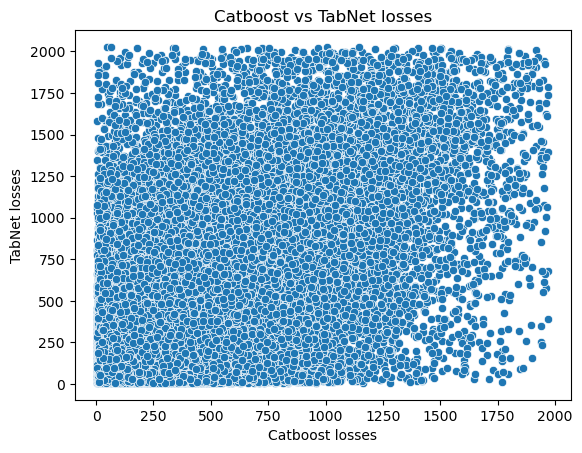

In [34]:
import numpy as np

# Calculate the 1st and 99th percentile of catboost_losses
q_low_cat = df_loss["catboost_losses"].quantile(0.01)
q_hi_cat  = df_loss["catboost_losses"].quantile(0.99)

# Filter out the outliers
df_filtered_cat = df_loss[(df_loss["catboost_losses"] < q_hi_cat) & (df_loss["catboost_losses"] > q_low_cat)]

# Calculate the 1st and 99th percentile of tabnet_losses
q_low_tab = df_filtered_cat["tabnet_losses"].quantile(0.01)
q_hi_tab  = df_filtered_cat["tabnet_losses"].quantile(0.99)

# Filter out the outliers
df_filtered = df_filtered_cat[(df_filtered_cat["tabnet_losses"] < q_hi_tab) & (df_filtered_cat["tabnet_losses"] > q_low_tab)]

# Now plot the filtered data
sns.scatterplot(data=df_filtered, x="catboost_losses", y="tabnet_losses")
plt.xlabel("Catboost losses")
plt.ylabel("TabNet losses")
plt.title("Catboost vs TabNet losses")
plt.show()


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 1st and 99th percentile of catboost_losses
q_low_cat = df_loss["catboost_losses"].quantile(0.1)
q_hi_cat  = df_loss["catboost_losses"].quantile(0.9)

# Filter out the outliers
df_filtered_cat = df_loss[(df_loss["catboost_losses"] < q_hi_cat) & (df_loss["catboost_losses"] > q_low_cat)]

# Calculate the 1st and 99th percentile of tabnet_losses
q_low_tab = df_filtered_cat["tabnet_losses"].quantile(0.1)
q_hi_tab  = df_filtered_cat["tabnet_losses"].quantile(0.9)

# Filter out the outliers
df_filtered = df_filtered_cat[(df_filtered_cat["tabnet_losses"] < q_hi_tab) & (df_filtered_cat["tabnet_losses"] > q_low_tab)]

# Now plot the filtered data
sns.jointplot(data=df_filtered, x="catboost_losses", y="tabnet_losses", kind='hex')
plt.xlabel("Catboost losses")
plt.ylabel("TabNet losses")
plt.suptitle("Catboost vs TabNet losses", y=1.02)
plt.show()


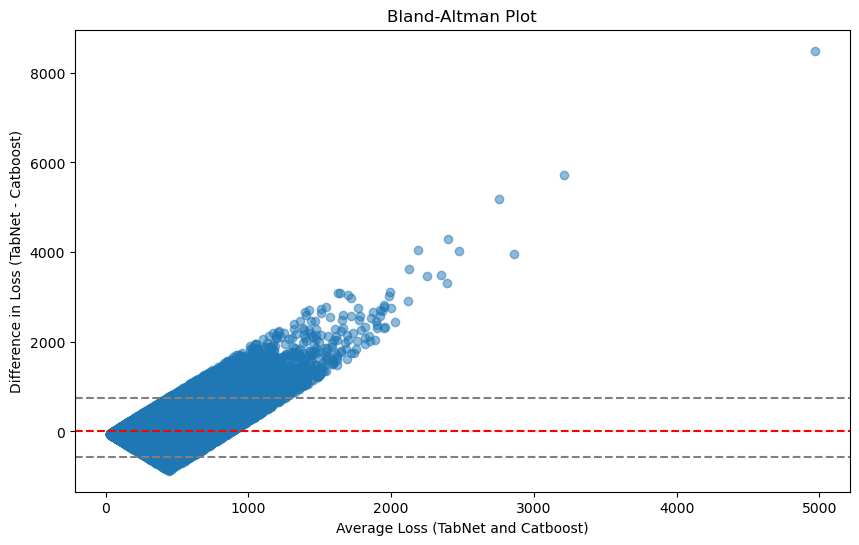

In [37]:
import matplotlib.pyplot as plt

# Calculate averages and differences
averages = [(x + y) / 2 for x, y in zip(df_filtered_cat["tabnet_losses"], df_filtered_cat["catboost_losses"])]
differences = [x - y for x, y in zip(df_filtered_cat["tabnet_losses"], df_filtered_cat["catboost_losses"])]

# Create the plot
plt.figure(figsize=(10,6))
plt.scatter(averages, differences, alpha=0.5)

# Optional: Draw a horizontal line at y=0 to make it easier to see positive and negative differences
plt.axhline(0, color='red', linestyle='--')

# Add the limits of agreement lines
plt.axhline(np.mean(differences) + 1.96 * np.std(differences), color='gray', linestyle='--')
plt.axhline(np.mean(differences) - 1.96 * np.std(differences), color='gray', linestyle='--')


plt.title('Bland-Altman Plot')
plt.xlabel('Average Loss (TabNet and Catboost)')
plt.ylabel('Difference in Loss (TabNet - Catboost)')
plt.show()
